# 03.2e: Jet Direction - Angular Separation from Bulk

**Goal:** Determine whether the jet is in the same direction as the bulk (radial spread) or angularly separated (different direction).

We'll compute:
1. **Direction vector to global centroid** (γ origin → γ' origin)
2. **Direction vector to jet centroid** (γ origin → jet center)
3. **Cosine similarity** between these directions
4. **Angular separation** in degrees

**Interpretation:**
- High cosine (near 1.0): Jet is in same direction as bulk, just farther out (radial spread)
- Low cosine (near 0.0): Jet is perpendicular to bulk (angular separation)
- Negative cosine: Jet is in opposite direction (very unlikely)

This reveals whether training pushed tokens uniformly outward or whether jet and bulk diverged in different directions.

## Parameters

In [1]:
TENSOR_DIR = "../data/tensors"

## Imports

In [2]:
import torch
import numpy as np
from safetensors.torch import load_file
from pathlib import Path
import matplotlib.pyplot as plt

print("Imports loaded successfully.")

Imports loaded successfully.


## Step 1: Load Data

In [3]:
# Load original gamma (uncentered)
gamma_path = Path(TENSOR_DIR) / "gamma_qwen3_4b_instruct_2507.safetensors"
gamma = load_file(gamma_path)['gamma']

N, d = gamma.shape

print(f"Loaded γ (original, uncentered):")
print(f"  Tokens: {N:,}")
print(f"  Dimensions: {d:,}")
print()

# Load jet mask
jet_mask_path = Path(TENSOR_DIR) / "jet_mask.safetensors"
jet_mask = load_file(jet_mask_path)['jet_mask']

n_jet = jet_mask.sum().item()
n_bulk = (~jet_mask).sum().item()

print(f"Loaded jet mask:")
print(f"  Jet tokens: {n_jet:,} ({n_jet/N*100:.2f}%)")
print(f"  Bulk tokens: {n_bulk:,} ({n_bulk/N*100:.2f}%)")

Loaded γ (original, uncentered):
  Tokens: 151,936
  Dimensions: 2,560

Loaded jet mask:
  Jet tokens: 3,055 (2.01%)
  Bulk tokens: 148,881 (97.99%)


## Step 2: Compute Direction Vectors

In [4]:
# Global centroid (entire cloud)
global_centroid = gamma.mean(dim=0)
global_centroid_norm = global_centroid.norm().item()

# Jet centroid
jet_centroid = gamma[jet_mask].mean(dim=0)
jet_centroid_norm = jet_centroid.norm().item()

# Bulk centroid (for additional context)
bulk_centroid = gamma[~jet_mask].mean(dim=0)
bulk_centroid_norm = bulk_centroid.norm().item()

print(f"Centroids computed:")
print(f"  Global: norm = {global_centroid_norm:.6f} gamma units")
print(f"  Jet:    norm = {jet_centroid_norm:.6f} gamma units")
print(f"  Bulk:   norm = {bulk_centroid_norm:.6f} gamma units")

Centroids computed:
  Global: norm = 0.304777 gamma units
  Jet:    norm = 0.465140 gamma units
  Bulk:   norm = 0.303751 gamma units


## Step 3: Normalize Direction Vectors

Convert to unit vectors for angular comparison.

In [5]:
# Normalize to unit vectors
global_direction = global_centroid / global_centroid.norm()
jet_direction = jet_centroid / jet_centroid.norm()
bulk_direction = bulk_centroid / bulk_centroid.norm()

print(f"Direction vectors (unit length):")
print(f"  Global: norm = {global_direction.norm().item():.6f} (should be 1.0)")
print(f"  Jet:    norm = {jet_direction.norm().item():.6f} (should be 1.0)")
print(f"  Bulk:   norm = {bulk_direction.norm().item():.6f} (should be 1.0)")

Direction vectors (unit length):
  Global: norm = 1.000000 (should be 1.0)
  Jet:    norm = 1.000000 (should be 1.0)
  Bulk:   norm = 1.000000 (should be 1.0)


## Step 4: Compute Cosine Similarities

In [6]:
# Cosine similarity: dot product of unit vectors
cosine_global_jet = (global_direction @ jet_direction).item()
cosine_global_bulk = (global_direction @ bulk_direction).item()
cosine_jet_bulk = (jet_direction @ bulk_direction).item()

print("\n" + "="*60)
print("COSINE SIMILARITIES (Angular Alignment)")
print("="*60 + "\n")

print(f"Global ↔ Jet:   {cosine_global_jet:.6f}")
print(f"Global ↔ Bulk:  {cosine_global_bulk:.6f}")
print(f"Jet ↔ Bulk:     {cosine_jet_bulk:.6f}")
print()

print("Interpretation:")
print(f"  1.0 = parallel (same direction)")
print(f"  0.0 = orthogonal (perpendicular)")
print(f" -1.0 = antiparallel (opposite directions)")


COSINE SIMILARITIES (Angular Alignment)

Global ↔ Jet:   0.769119
Global ↔ Bulk:  0.999798
Jet ↔ Bulk:     0.756129

Interpretation:
  1.0 = parallel (same direction)
  0.0 = orthogonal (perpendicular)
 -1.0 = antiparallel (opposite directions)


## Step 5: Compute Angular Separations

In [7]:
# Convert cosines to angles
angle_global_jet_rad = np.arccos(np.clip(cosine_global_jet, -1, 1))
angle_global_bulk_rad = np.arccos(np.clip(cosine_global_bulk, -1, 1))
angle_jet_bulk_rad = np.arccos(np.clip(cosine_jet_bulk, -1, 1))

angle_global_jet_deg = np.degrees(angle_global_jet_rad)
angle_global_bulk_deg = np.degrees(angle_global_bulk_rad)
angle_jet_bulk_deg = np.degrees(angle_jet_bulk_rad)

print("\n" + "="*60)
print("ANGULAR SEPARATIONS")
print("="*60 + "\n")

print(f"Global ↔ Jet:   {angle_global_jet_deg:.2f}° ({angle_global_jet_rad:.4f} rad)")
print(f"Global ↔ Bulk:  {angle_global_bulk_deg:.2f}° ({angle_global_bulk_rad:.4f} rad)")
print(f"Jet ↔ Bulk:     {angle_jet_bulk_deg:.2f}° ({angle_jet_bulk_rad:.4f} rad)")
print()

print("Reference angles:")
print(f"   0° = same direction")
print(f"  45° = moderate separation")
print(f"  90° = perpendicular")
print(f" 180° = opposite directions")


ANGULAR SEPARATIONS

Global ↔ Jet:   39.73° (0.6933 rad)
Global ↔ Bulk:  1.15° (0.0201 rad)
Jet ↔ Bulk:     40.88° (0.7134 rad)

Reference angles:
   0° = same direction
  45° = moderate separation
  90° = perpendicular
 180° = opposite directions


## Step 6: Interpret Results

In [8]:
print("\n" + "="*60)
print("INTERPRETATION")
print("="*60 + "\n")

# Global vs Jet
print(f"Global centroid → Jet centroid: {angle_global_jet_deg:.2f}°")
if angle_global_jet_deg < 15:
    print(f"  → Nearly aligned! Jet is in same direction as cloud, just farther out.")
    print(f"  → This suggests radial spread during training.")
elif angle_global_jet_deg < 45:
    print(f"  → Moderately aligned. Jet is mostly in same direction but slightly off.")
    print(f"  → Training pushed jet and bulk in similar but not identical directions.")
elif angle_global_jet_deg < 75:
    print(f"  → Significant angular separation. Jet and bulk diverged.")
    print(f"  → Training differentiated these token populations.")
else:
    print(f"  → Large angular separation! Jet is in very different direction.")
    print(f"  → These tokens evolved independently during training.")

print()

# Jet vs Bulk
print(f"Jet centroid ↔ Bulk centroid: {angle_jet_bulk_deg:.2f}°")
if angle_jet_bulk_deg < 15:
    print(f"  → Jet and bulk point in nearly the same direction!")
    print(f"  → Difference is primarily radial (distance), not angular.")
else:
    print(f"  → Jet and bulk have angular separation.")
    print(f"  → These populations occupy different regions of hyperspace.")


INTERPRETATION

Global centroid → Jet centroid: 39.73°
  → Moderately aligned. Jet is mostly in same direction but slightly off.
  → Training pushed jet and bulk in similar but not identical directions.

Jet centroid ↔ Bulk centroid: 40.88°
  → Jet and bulk have angular separation.
  → These populations occupy different regions of hyperspace.


## Step 7: Visualize Angular Relationships

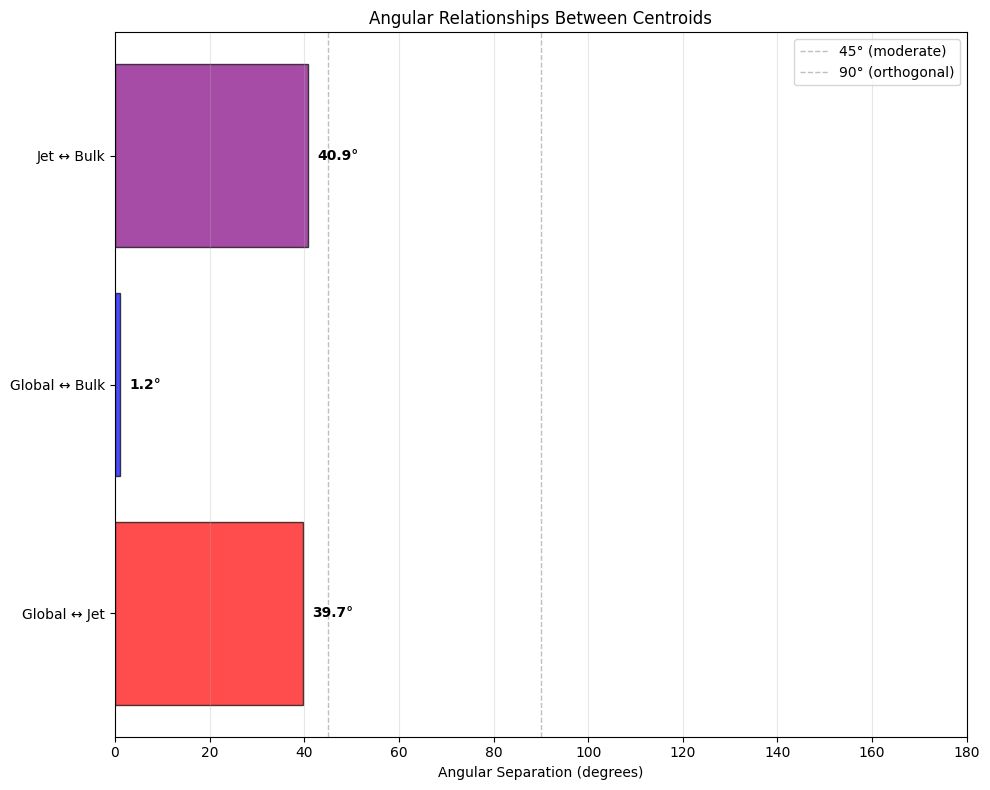


Smaller angles indicate closer alignment in hyperspace.
Larger angles indicate greater angular separation.


In [9]:
fig, ax = plt.subplots(figsize=(10, 8), dpi=100)

# Create a simple visualization showing angular separations
# We'll plot as a "triangle" showing the three pairwise angles

angles = {
    'Global ↔ Jet': angle_global_jet_deg,
    'Global ↔ Bulk': angle_global_bulk_deg,
    'Jet ↔ Bulk': angle_jet_bulk_deg
}

labels = list(angles.keys())
values = list(angles.values())
colors = ['red', 'blue', 'purple']

bars = ax.barh(labels, values, color=colors, alpha=0.7, edgecolor='black')
ax.set_xlabel('Angular Separation (degrees)')
ax.set_title('Angular Relationships Between Centroids')
ax.grid(True, alpha=0.3, axis='x')
ax.set_xlim(0, 180)

# Add reference lines
ax.axvline(45, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='45° (moderate)')
ax.axvline(90, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='90° (orthogonal)')
ax.legend(loc='upper right')

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, values)):
    ax.text(val + 2, i, f'{val:.1f}°', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nSmaller angles indicate closer alignment in hyperspace.")
print("Larger angles indicate greater angular separation.")

## Summary

We computed the angular relationship between jet and bulk centroids.

**Key findings:**
- Global ↔ Jet angular separation: ???°
- Global ↔ Bulk angular separation: ???°
- Jet ↔ Bulk angular separation: ???°

**Geometric interpretation:**

If angles are small (<15°):
- Jet and bulk are nearly collinear with the origin
- Training pushed tokens radially outward in roughly the same direction
- The cloud has a "comet tail" structure

If angles are moderate (15-45°):
- Jet and bulk diverged slightly during training
- The cloud has a "forked" structure

If angles are large (>45°):
- Jet and bulk occupy fundamentally different regions
- Training created distinct directional clusters
- The jet is not just "farther out bulk" but a separate population